In [1]:
import sys
import os
import warnings
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from dotenv import load_dotenv
import google.generativeai as genai

if str(Path().resolve().parent) not in sys.path:
    sys.path.append(str(Path().resolve().parent))

load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

warnings.filterwarnings("ignore", category=FutureWarning)

from src.config import random_seed, PREPROCESSED_BLOG_DATASET_PATH, CLASSIFICATION_MAP
from src.models_setup import gemini_2_flash, gemini_2_flash_lite, gemini_1_5_flash
from src.prompts import *
from src.output_formats import *
from src.helpers import extract_llm_assessment

# Data Processing

In [2]:
# Import data
blogs = pd.read_csv(PREPROCESSED_BLOG_DATASET_PATH)

# Split dataset into validation and test set
Xval, Xtest, yval_score, ytest_score = train_test_split(
    blogs.drop(columns=['normalized_engagement_score']), blogs["normalized_engagement_score"],
    test_size=0.4, random_state=random_seed)

# Same Xval, Xtest; new explained variable "engagement_level"
Xval, Xtest, yval_level, ytest_level = train_test_split(
    blogs.drop(columns=['engagement_level', 'normalized_engagement_score']), blogs["engagement_level"],
    test_size=0.4, random_state=random_seed)

print(f"Size of validation set, X: {Xval.shape}, y: {yval_score.shape}")
print(f"Size of test set, X: {Xtest.shape}, y: {ytest_score.shape}")

Size of validation set, X: (30, 11), y: (30,)
Size of test set, X: (20, 11), y: (20,)


In [3]:
# The best blog in dataset
best_blog_info = Xval.sort_values(["engagement_score"], ascending=False).head(1)
best_blog_index = best_blog_info.index[0]
best_blog_info = best_blog_info.reset_index(drop=True)
best_blog_info

,id,title_blog,url_blog,author_blog,author_followers,claps,comments,title_paper,url_paper,engagement_score,blog_full_text
0,28,Towards Reasoning,https://medium.com/@saptarshichaudhuri/towards...,Saptarshi Chaudhuri,127,461,1,GSM-Symbolic: Understanding the Limitations of...,https://arxiv.org/pdf/2410.05229?source=post_p...,3.653543,# Towards Reasoning\nGlorified next token pred...


In [4]:
# The worst blog in dataset
worst_blog_info = Xval.sort_values(["engagement_score"], ascending=False).tail(1)
worst_blog_index = worst_blog_info.index[0]
worst_blog_info = worst_blog_info.reset_index(drop=True)
worst_blog_info

,id,title_blog,url_blog,author_blog,author_followers,claps,comments,title_paper,url_paper,engagement_score,blog_full_text
0,18,SMoA: Improving Multi-agent Large Language Mod...,https://medium.com/@sulbha.jindal/smoa-improvi...,Sulbha Jain,41,0,0,SMoA: Improving Multi-agent Large Language Mod...,https://arxiv.org/pdf/2411.03284,0.0,# SMoA: Improving Multi-agent Large Language M...


In [5]:
blog_text = blogs.loc[16, "blog_full_text"]
print(blog_text)

# Self-Generated Critiques Boost Reward Modeling for LanguageModels — Paper Review
Paper — https://arxiv.org/pdf/2411.16646
Reinforcement Learning from Human Feedback (RLHF) has become a critical methodology for aligning large language models (LLMs) with human preferences. At the core of RLHF lies the reward model (RM), which is designed to evaluate model outputs by assigning scores that reflect their alignment with human judgments. These scores guide the optimization process during training, such as providing reward signals in Proximal Policy Optimization (PPO), thereby encouraging LLMs to generate responses that are more helpful, honest, and harmless. This iterative process enhances the practical quality of LLM outputs in real-world applications.

## Current challenge
Typically, reward models are trained using preference pairs and optimized through pairwise logistic loss to produce a scalar score for each response. However, this scalar output is often hard to interpret and underutili

In [6]:
best_blog = {
    "blog": best_blog_info.loc[0, "blog_full_text"],
    "score" : yval_score.loc[best_blog_index]
}
worst_blog = {
    "blog" : worst_blog_info.loc[0, "blog_full_text"],
    "score" : yval_score.loc[worst_blog_index]
}

In [7]:
excellent_blog_index = yval_level[yval_level == "Excellent"].index.min()
excellent_blog = blogs.loc[excellent_blog_index, "blog_full_text"]
with open("../data/examples/excellent_blog", "w", encoding="utf-8") as file:
    file.write(excellent_blog)

very_good_blog_index = yval_level[yval_level == "Very Good"].index.min()
very_good_blog = blogs.loc[very_good_blog_index, "blog_full_text"]
with open("../data/examples/very_good_blog", "w", encoding="utf-8") as file:
    file.write(very_good_blog)

good_blog_index = yval_level[yval_level == "Good"].index.min()
good_blog = blogs.loc[good_blog_index, "blog_full_text"]
with open("../data/examples/good_blog", "w", encoding="utf-8") as file:
    file.write(good_blog)

average_blog_index = yval_level[yval_level == "Average"].index.min()
average_blog = blogs.loc[average_blog_index, "blog_full_text"]
with open("../data/examples/average_blog", "w", encoding="utf-8") as file:
    file.write(average_blog)

bad_blog_index = yval_level[yval_level == "Bad"].index.min()
bad_blog = blogs.loc[bad_blog_index, "blog_full_text"]
with open("../data/examples/bad_blog", "w", encoding="utf-8") as file:
    file.write(bad_blog)

# Prompt Engineering

In [7]:
def test_prompt(prompt_template, model, input_variables):
    """Testing the operation of LLM with a given prompt template."""
    test_chain = prompt_template | model
    test_response = test_chain.invoke(input_variables)
    print(f"Usage metadata:\n{test_response.usage_metadata}")
    print(f"\nContent:\n{test_response.content}")

In [8]:
# One word answer
test_prompt(prompt_simple_answer, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1138, 'output_tokens': 3, 'total_tokens': 1141, 'input_token_details': {'cache_read': 0}}

Content:
Informative


In [9]:
# Adding numerical assessment
test_prompt(prompt_numeric_rating, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1143, 'output_tokens': 9, 'total_tokens': 1152, 'input_token_details': {'cache_read': 0}}

Content:
Informative - 8/10


In [10]:
# Scale from 1 to 100 + short comment
test_prompt(prompt_short_comment, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1154, 'output_tokens': 102, 'total_tokens': 1256, 'input_token_details': {'cache_read': 0}}

Content:
**Rating: 85/100**

**Comment:** This is a well-written and concise summary of the Critic-RM paper. It clearly explains the motivation, methodology, results, and significance of the research. The explanation of the core concepts is easy to follow, and the inclusion of the paper link is helpful. A slightly deeper dive into the specific filtering/summarization/ranking techniques used might elevate it further, but as a high-level overview, it's excellent.


In [11]:
# Emphasizing the importance of engagement
test_prompt(prompt_engagement_score, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1160, 'output_tokens': 80, 'total_tokens': 1240, 'input_token_details': {'cache_read': 0}}

Content:
**Engagement Level: 55/100**

**Comment:** The blog post provides a well-structured summary of a research paper, making it informative and accessible. However, the engagement level is moderate. This could be improved by incorporating interactive elements like questions for the reader, discussion prompts, or comparisons to related work. Including visuals or code snippets would also make it more engaging.


In [12]:
# Assessment based on several criteria
test_prompt(prompt_criteria, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1184, 'output_tokens': 375, 'total_tokens': 1559, 'input_token_details': {'cache_read': 0}}

Content:
**Assessment:**

*   **Readability:** The text is generally well-written and uses clear language, though some familiarity with LLM and RLHF concepts is assumed. Technical terms are explained, but briefly. (Score: 75)
*   **Structure:** The blog post follows a logical structure: introduction, problem statement, proposed solution, methodology, results, and summary. The use of headings and subheadings improves readability. (Score: 85)
*   **Attractiveness of the Blog Title:** The title is descriptive and informative, but not particularly catchy. It clearly states the content of the review. (Score: 65)
*   **Clarity:** The explanation of the Critic-RM methodology is relatively clear, although a deeper understanding of the underlying mathematical formulas may require reading the original paper. (Score: 70)
*   **Audience Appeal:** The blog post is targeted t

In [13]:
# Separate assessment
test_prompt(prompt_separate_assessment, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1211, 'output_tokens': 808, 'total_tokens': 2019, 'input_token_details': {'cache_read': 0}}

Content:
Okay, here's an analysis of the blog post's engagement level based on the criteria you provided, along with individual scores and an overall assessment:

**Criterion Breakdown and Scores (out of 100):**

*   **Readability (75/100):** The writing is generally clear and concise. It avoids overly complex jargon, but some familiarity with LLMs and RLHF is assumed. The use of headings and subheadings helps break up the text. However, the inclusion of mathematical notation ($$(x, y)$$, $$z \sim q_\phi(x, y)$$, $$r = r_\psi(x, [y, z])$$) can reduce readability for those unfamiliar with such notation.
*   **Structure (85/100):** The blog post follows a logical structure. It begins with an introduction to RLHF and reward models, then outlines the challenges, presents the Critic-RM methodology, discusses the results, and concludes with a summary. The use of headi

In [14]:
# Add information about profile of the model
test_prompt(prompt_with_profile, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1239, 'output_tokens': 713, 'total_tokens': 1952, 'input_token_details': {'cache_read': 0}}

Content:
Okay, here's my analysis of the blog post, broken down by the criteria you provided, and culminating in an overall assessment:

**Criterion Breakdown:**

*   **Readability (75/100):** The blog post utilizes technical language that, while necessary for the subject matter, can be challenging for readers without a background in machine learning or natural language processing. The use of bullet points and clear headings improves readability. However, the density of technical terms could be reduced with more explanation.
*   **Structure (90/100):** The blog follows a clear and logical structure: introduction, problem statement ("Current challenge"), proposed solution ("Methodology"), results, and summary. The use of headings and subheadings makes it easy to follow the main points. The inclusion of a direct link to the paper in both the intro and the Appendix

In [15]:
# Well-structured sections of the prompt
test_prompt(prompt_structured_sections, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1342, 'output_tokens': 812, 'total_tokens': 2154, 'input_token_details': {'cache_read': 0}}

Content:
Okay, here's an evaluation of the blog post, focusing on the textual content and its effectiveness in communicating scientific research to a broader audience.

**Scores and Comments:**

*   **Readability:** 70/100 - The writing is generally clear, but the density of technical terms ("Proximal Policy Optimization," "pairwise logistic loss," "knowledge distillation") without extensive explanation can hinder readability for a broader audience. Some sentences are also a bit long and complex.
*   **Structure:** 80/100 - The blog follows a logical structure: introduction, problem statement, proposed solution (methodology), results, and summary. The use of headings and subheadings is effective in breaking up the text.
*   **Informativeness:** 85/100 - The blog provides a good overview of the research paper, covering the key aspects of the problem, the proposed

In [17]:
# 2-shot prompt
test_prompt(prompt_two_shots, gemini_2_flash, {
    "blog_text" : blog_text,
    "blog_ex1" : best_blog["blog"],
    "score_ex1" : best_blog["score"],
    "blog_ex2" : worst_blog["blog"],
    "score_ex2" : worst_blog["score"]
})

Usage metadata:
{'input_tokens': 3292, 'output_tokens': 488, 'total_tokens': 3780, 'input_token_details': {'cache_read': 0}}

Content:
```json
{
  "overall_assessment": 60,
  "explanation": "The blog post provides a decent overview of the research paper, explaining the key concepts and methodology in a way that's understandable for readers with some background in machine learning or NLP. However, there are areas where it could be improved to enhance clarity and engagement.\n\nReadability: The text is generally readable, but the inclusion of formulas without sufficient context might deter some readers. \nStructure: The structure is logical, with clear sections like \"Current challenge,\" \"Methodology,\" \"Results,\" and \"Summary.\" This makes it easy to follow the main points of the paper. However, some sections could benefit from further elaboration.\nInformativeness: The blog provides a good summary of the paper's key contributions and findings. However, it lacks depth in explaining

In [19]:
# 5-shot prompt with verbal classification
test_prompt(prompt_five_shots, gemini_2_flash, {
    "blog_text": blog_text,
    "excellent_blog": excellent_blog,
    "very_good_blog": very_good_blog,
    "good_blog": good_blog,
    "average_blog": average_blog,
    "bad_blog": bad_blog
})

Usage metadata:
{'input_tokens': 11803, 'output_tokens': 325, 'total_tokens': 12128, 'input_token_details': {'cache_read': 0}}

Content:
```json
{
  "engagement_level": "Good",
  "explanation": "The blog post presents a decent overview of the research paper on Critic-RM, a framework for enhancing reward modeling in LLMs using self-generated critiques. The structure is logical, presenting the background, challenges, methodology, results, and a summary. The information is relatively clear, although some sections require familiarity with RLHF and LLM concepts. However, the blog lacks a strong hook and engaging elements that would significantly increase its appeal to a broader audience.",
  "possible_improvements": [
    "Add a more engaging introduction to capture the reader's attention, such as a real-world problem or a relatable scenario where improved reward modeling can make a difference.",
    "Simplify complex technical terms and concepts to make the blog more accessible to readers 

In [20]:
# Zero-shot Chain-of-Thoughts
test_prompt(prompt_zero_cot, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1412, 'output_tokens': 620, 'total_tokens': 2032, 'input_token_details': {'cache_read': 0}}

Content:
```json
{
  "analysis": {
    "readability": "The readability is moderate. While the language is generally clear, the presence of technical terms like 'Proximal Policy Optimization (PPO),' 'pairwise logistic loss,' and mathematical notations such as '$$r = r_\\psi(x, [y, z])$$' without sufficient context may hinder comprehension for readers unfamiliar with machine learning. The writing style is somewhat academic, which might deter a broader audience.",
    "structure": "The blog follows a logical structure, starting with an introduction to RLHF and reward models, then moving to the challenges, the proposed methodology (Critic-RM), results, and a summary. The use of headings and subheadings helps to break up the text and improve readability. The structure is sound and aids in understanding the topic.",
    "informativeness": "The blog provides a decent o

In [21]:
# Generated knowledge
test_prompt(prompt_generated_knowledge, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1395, 'output_tokens': 904, 'total_tokens': 2299, 'input_token_details': {'cache_read': 0}}

Content:
```json
{
  "key_analysis": {
    "readability": "Assess sentence structure, vocabulary, and the use of jargon. Aim for clarity and conciseness, making the content accessible to a broad audience without sacrificing accuracy.",
    "structure": "Evaluate the logical flow of information, the use of headings and subheadings, and the overall organization of the blog post. A well-structured post is easy to follow and understand.",
    "informativeness": "Determine the depth and breadth of the information provided. Does the blog post adequately explain the research and its implications? Is the information accurate and up-to-date?",
    "attractiveness_of_blog_title": "Analyze how well the title captures the essence of the blog post and its ability to draw the reader in. A good title is both informative and intriguing.",
    "clarity": "Examine the lucidity of

In [22]:
# Meta prompt
test_prompt(prompt_meta, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1595, 'output_tokens': 709, 'total_tokens': 2304, 'input_token_details': {'cache_read': 0}}

Content:
```json
{
    "Referenced blog to evaluate": "Self-Generated Critiques Boost Reward Modeling for LanguageModels — Paper Review",
    "Step 1": "Analyze the readability of the blog. Is the text easy to understand? Are the sentences clear and well-structured? The readability is moderate. While the sentences are generally well-structured, the technical jargon and concepts related to LLMs and reinforcement learning might be challenging for readers without a background in the field. The use of abbreviations like RLHF and PPO without consistent initial explanation hurts readability.",
    "Step 2": "Evaluate the structure of the blog. Does it follow a logical flow? Are the sections well-organized? The structure is logical. It starts with an introduction to RLHF and reward models, presents the challenges, explains the methodology of Critic-RM, discusses the re

# Performance testing on a validation set

In [8]:
def show_scatter_plot(real_values, predicted_values):
    plt.scatter(real_values, predicted_values, color='blue')
    plt.plot([min(real_values), max(real_values)], [min(real_values), max(real_values)], color='red', linestyle='--')
    plt.xlabel('Real values')
    plt.ylabel('Predicted values')
    plt.title('Real vs Predicted values')
    plt.show()

In [9]:
# Models
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogEvaluation, include_raw=True)
gemini_2_flash_lite_structured = gemini_2_flash_lite.with_structured_output(BlogEvaluation, include_raw=True)
gemini_1_5_flash_structured = gemini_1_5_flash.with_structured_output(BlogEvaluation, include_raw=True)

## Numeric evaluation with two-shot prompt


### Gemini 2.0 Flash

In [10]:
flash_assessment = extract_llm_assessment(Xval, prompt_two_shots, gemini_2_flash_structured,
                                        {
                                            "blog_ex1" : best_blog["blog"],
                                            "score_ex1" : best_blog["score"],
                                            "blog_ex2" : worst_blog["blog"],
                                            "score_ex2" : worst_blog["score"]
                                        })

In [11]:
flash_RMSE_val = metrics.root_mean_squared_error(yval_score, flash_assessment)
print(f"Root Mean Square Error on validation set: {flash_RMSE_val:.1f}")
flash_MAE_val = metrics.mean_absolute_error(yval_score, flash_assessment)
print(f"Mean Absolute Error on validation set: {flash_MAE_val:.1f}")

Root Mean Square Error on validation set: 44.2
Mean Absolute Error on validation set: 37.1


### Gemini 2.0 Flash-Lite

In [12]:
lite_assessment = extract_llm_assessment(Xval, prompt_two_shots, gemini_2_flash_lite_structured,
                                        {
                                            "blog_ex1" : best_blog["blog"],
                                            "score_ex1" : best_blog["score"],
                                            "blog_ex2" : worst_blog["blog"],
                                            "score_ex2" : worst_blog["score"]
                                        })

In [13]:
lite_RMSE_val = metrics.root_mean_squared_error(yval_score, lite_assessment)
print(f"Root Mean Square Error on validation set: {lite_RMSE_val:.1f}")
lite_MAE_val = metrics.mean_absolute_error(yval_score, lite_assessment)
print(f"Mean Absolute Error on validation set: {lite_MAE_val:.1f}")

Root Mean Square Error on validation set: 44.7
Mean Absolute Error on validation set: 39.5


### Gemini 1.5 Flash

In [14]:
flash1_assessment = extract_llm_assessment(Xval, prompt_two_shots, gemini_1_5_flash_structured,
                                        {
                                            "blog_ex1" : best_blog["blog"],
                                            "score_ex1" : best_blog["score"],
                                            "blog_ex2" : worst_blog["blog"],
                                            "score_ex2" : worst_blog["score"]
                                        })

In [15]:
flash1_RMSE_val = metrics.root_mean_squared_error(yval_score, flash1_assessment)
print(f"Root Mean Square Error on validation set: {flash1_RMSE_val:.1f}")
flash1_MAE_val = metrics.mean_absolute_error(yval_score, flash1_assessment)
print(f"Mean Absolute Error on validation set: {flash1_MAE_val:.1f}")

Root Mean Square Error on validation set: 46.3
Mean Absolute Error on validation set: 39.9


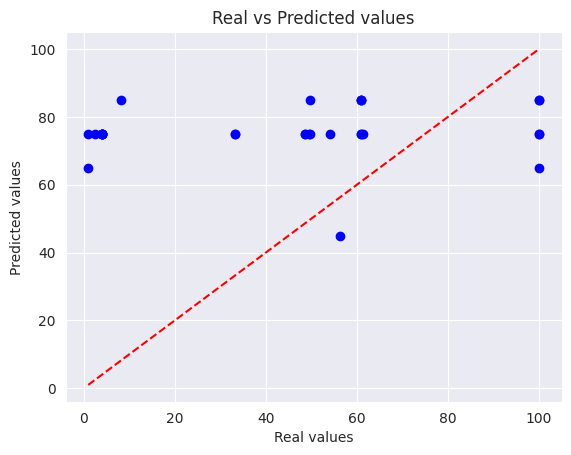

In [16]:
show_scatter_plot(yval_score, flash1_assessment)

## Normalized numeric evaluation with two-shot prompt

### Gemini 2.0 Flash

In [17]:
flash_assessment_scaler = MinMaxScaler(feature_range=(1, 100))
scaled_flash_assessment = flash_assessment_scaler.fit_transform(flash_assessment.values.reshape(-1, 1))
flash_RMSE_val_scaled = metrics.root_mean_squared_error(yval_score, scaled_flash_assessment)
print(f"Root Mean Square Error on validation set after MinMax normalization of LLM output: {flash_RMSE_val_scaled:.1f}")
flash_MAE_val_scaled = metrics.mean_absolute_error(yval_score, scaled_flash_assessment)
print(f"Mean Absolute Error on validation set after MinMax normalization of LLM output: {flash_MAE_val_scaled:.1f}")

Root Mean Square Error on validation set after MinMax normalization of LLM output: 38.7
Mean Absolute Error on validation set after MinMax normalization of LLM output: 30.9


### Gemini 2.0 Flash-Lite

In [18]:
lite_assessment_scaler = MinMaxScaler(feature_range=(1, 100))
scaled_lite_assessment = lite_assessment_scaler.fit_transform(lite_assessment.values.reshape(-1, 1))
lite_RMSE_val_scaled = metrics.root_mean_squared_error(yval_score, scaled_lite_assessment)
print(f"Root Mean Square Error on validation set after MinMax normalization of LLM output (Lite): {lite_RMSE_val_scaled:.1f}")
lite_MAE_val_scaled = metrics.mean_absolute_error(yval_score, scaled_lite_assessment)
print(f"Mean Absolute Error on validation set after MinMax normalization of LLM output (Lite): {lite_MAE_val_scaled:.1f}")

Root Mean Square Error on validation set after MinMax normalization of LLM output (Lite): 46.8
Mean Absolute Error on validation set after MinMax normalization of LLM output (Lite): 41.2


### Gemini 1.5 Flash

In [19]:
flash1_assessment_scaler = MinMaxScaler(feature_range=(1, 100))
scaled_flash1_assessment = flash1_assessment_scaler.fit_transform(flash1_assessment.values.reshape(-1, 1))
flash1_RMSE_val_scaled = metrics.root_mean_squared_error(yval_score, scaled_flash1_assessment)
print(f"Root Mean Square Error on validation set after MinMax normalization of LLM output (Flash 1.5): {flash1_RMSE_val_scaled:.1f}")
flash1_MAE_val_scaled = metrics.mean_absolute_error(yval_score, scaled_flash1_assessment)
print(f"Mean Absolute Error on validation set after MinMax normalization of LLM output (Flash 1.5): {flash1_MAE_val_scaled:.1f}")

Root Mean Square Error on validation set after MinMax normalization of LLM output (Flash 1.5): 49.4
Mean Absolute Error on validation set after MinMax normalization of LLM output (Flash 1.5): 43.0


## Classification with five-shot prompt

In [20]:
# Models
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassification, include_raw=True)
gemini_2_flash_lite_structured = gemini_2_flash_lite.with_structured_output(BlogClassification, include_raw=True)
gemini_1_5_flash_structured = gemini_1_5_flash.with_structured_output(BlogClassification, include_raw=True)

### Gemini 2.0 Flash

In [21]:
flash_classification = extract_llm_assessment(Xval, prompt_five_shots, gemini_2_flash_structured,
                                            examples=
                                            {
                                                "excellent_blog" : excellent_blog,
                                                "very_good_blog" : very_good_blog,
                                                "good_blog" : good_blog,
                                                "average_blog" : average_blog,
                                                "bad_blog" : bad_blog
                                            })

In [22]:
flash_accuracy = metrics.accuracy_score(yval_level, flash_classification)
print(f"Accuracy score on validation set: {flash_accuracy * 100:.2f}%")

flash_RMSE_val_verbal = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), flash_classification.map(CLASSIFICATION_MAP))
flash_MAE_val_verbal = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), flash_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using the verbal classification: {flash_RMSE_val_verbal:.1f}")
print(f"Mean Absolute Error on validation set after using verbal classification: {flash_MAE_val_verbal:.1f}")

Accuracy score on validation set: 50.00%
Root Mean Square Error on validation set after using the verbal classification: 1.4
Mean Absolute Error on validation set after using verbal classification: 0.9


### Gemini 2.0 Flash-Lite

In [23]:
lite_classification = extract_llm_assessment(Xval, prompt_five_shots, gemini_2_flash_lite_structured,
                                            examples=
                                            {
                                                "excellent_blog" : excellent_blog,
                                                "very_good_blog" : very_good_blog,
                                                "good_blog" : good_blog,
                                                "average_blog" : average_blog,
                                                "bad_blog" : bad_blog
                                            })

In [24]:
lite_accuracy = metrics.accuracy_score(yval_level, lite_classification)
print(f"Accuracy score on validation set: {lite_accuracy * 100:.2f}%")

lite_RMSE_val_verbal = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), lite_classification.map(CLASSIFICATION_MAP))
lite_MAE_val_verbal = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), lite_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using the verbal classification: {lite_RMSE_val_verbal:.1f}")
print(f"Mean Absolute Error on validation set after using verbal classification: {lite_MAE_val_verbal:.1f}")

Accuracy score on validation set: 36.67%
Root Mean Square Error on validation set after using the verbal classification: 1.7
Mean Absolute Error on validation set after using verbal classification: 1.2


### Gemini 1.5 Flash

In [25]:
flash1_classification = extract_llm_assessment(Xval, prompt_five_shots, gemini_1_5_flash_structured,
                                            examples=
                                            {
                                                "excellent_blog" : excellent_blog,
                                                "very_good_blog" : very_good_blog,
                                                "good_blog" : good_blog,
                                                "average_blog" : average_blog,
                                                "bad_blog" : bad_blog
                                            })

In [26]:
flash1_accuracy = metrics.accuracy_score(yval_level, flash1_classification)
print(f"Accuracy score on validation set: {flash1_accuracy * 100:.2f}%")

flash1_RMSE_val_verbal = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), flash1_classification.map(CLASSIFICATION_MAP))
flash1_MAE_val_verbal = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), flash1_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using the verbal classification: {flash1_RMSE_val_verbal:.1f}")
print(f"Mean Absolute Error on validation set after using verbal classification: {flash1_MAE_val_verbal:.1f}")

Accuracy score on validation set: 23.33%
Root Mean Square Error on validation set after using the verbal classification: 1.4
Mean Absolute Error on validation set after using verbal classification: 1.1


## Classification with Chain-of-Thoughts prompt

In [27]:
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassificationCoT, include_raw=True)
gemini_2_flash_lite_structured = gemini_2_flash_lite.with_structured_output(BlogClassificationCoT, include_raw=True)
gemini_1_5_flash_structured = gemini_1_5_flash.with_structured_output(BlogClassificationCoT, include_raw=True)

### Gemini 2.0 Flash

In [28]:
flash_cot_classification = extract_llm_assessment(Xval, prompt_zero_cot, gemini_2_flash_structured, examples={})

In [29]:
flash_cot_accuracy = metrics.accuracy_score(yval_level, flash_cot_classification)
print(f"Accuracy score on validation set: {flash_cot_accuracy * 100:.2f}%")

flash_RMSE_val_cot = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), flash_cot_classification.map(CLASSIFICATION_MAP))
flash_MAE_val_cot = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), flash_cot_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using Chain-of-Thoughts: {flash_RMSE_val_cot:.1f}")
print(f"Mean Absolute Error on validation set after using verbal Chain-of-Thoughts: {flash_MAE_val_cot:.1f}")

Accuracy score on validation set: 23.33%
Root Mean Square Error on validation set after using Chain-of-Thoughts: 1.5
Mean Absolute Error on validation set after using verbal Chain-of-Thoughts: 1.3


### Gemini 2.0 Flash-Lite

In [30]:
lite_cot_classification = extract_llm_assessment(Xval, prompt_zero_cot, gemini_2_flash_lite_structured, examples={})

In [31]:
lite_cot_accuracy = metrics.accuracy_score(yval_level, lite_cot_classification)
print(f"Accuracy score on validation set: {lite_cot_accuracy * 100:.2f}%")

lite_RMSE_val_cot = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), lite_cot_classification.map(CLASSIFICATION_MAP))
lite_MAE_val_cot = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), lite_cot_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using Chain-of-Thoughts: {lite_RMSE_val_cot:.1f}")
print(f"Mean Absolute Error on validation set after using verbal Chain-of-Thoughts: {lite_MAE_val_cot:.1f}")

Accuracy score on validation set: 26.67%
Root Mean Square Error on validation set after using Chain-of-Thoughts: 1.8
Mean Absolute Error on validation set after using verbal Chain-of-Thoughts: 1.4


### Gemini 1.5 Flash

In [32]:
flash1_cot_classification = extract_llm_assessment(Xval, prompt_zero_cot, gemini_1_5_flash_structured, examples={})

In [33]:
flash1_cot_accuracy = metrics.accuracy_score(yval_level, flash1_cot_classification)
print(f"Accuracy score on validation set: {flash1_cot_accuracy * 100:.2f}%")

flash1_RMSE_val_cot = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), flash1_cot_classification.map(CLASSIFICATION_MAP))
flash1_MAE_val_cot = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), flash1_cot_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using Chain-of-Thoughts: {flash1_RMSE_val_cot:.1f}")
print(f"Mean Absolute Error on validation set after using verbal Chain-of-Thoughts: {flash1_MAE_val_cot:.1f}")

Accuracy score on validation set: 10.00%
Root Mean Square Error on validation set after using Chain-of-Thoughts: 1.8
Mean Absolute Error on validation set after using verbal Chain-of-Thoughts: 1.6


## Classification with generated knowledge prompt

In [34]:
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassificationGK, include_raw=True)
gemini_2_flash_lite_structured = gemini_2_flash_lite.with_structured_output(BlogClassificationGK, include_raw=True)
gemini_1_5_flash_structured = gemini_1_5_flash.with_structured_output(BlogClassificationGK, include_raw=True)

### Gemini 2.0 Flash

In [ ]:
flash_gk_classification = extract_llm_assessment(Xval, prompt_generated_knowledge, gemini_2_flash_structured, examples={})

In [36]:
flash_gk_accuracy = metrics.accuracy_score(yval_level, flash_gk_classification)
print(f"Accuracy score on validation set: {flash_gk_accuracy * 100:.2f}%")

flash_RMSE_val_gk = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), flash_gk_classification.map(CLASSIFICATION_MAP))
flash_MAE_val_gk = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), flash_gk_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using generated knowledge: {flash_RMSE_val_gk:.1f}")
print(f"Mean Absolute Error on validation set after using generated knowledge: {flash_MAE_val_gk:.1f}")

Accuracy score on validation set: 23.33%
Root Mean Square Error on validation set after using generated knowledge: 1.7
Mean Absolute Error on validation set after using generated knowledge: 1.3


### Gemini 2.0 Flash-Lite

In [37]:
lite_gk_classification = extract_llm_assessment(Xval, prompt_generated_knowledge, gemini_2_flash_lite_structured, examples={})

In [38]:
lite_gk_accuracy = metrics.accuracy_score(yval_level, lite_gk_classification)
print(f"Accuracy score on validation set: {lite_gk_accuracy * 100:.2f}%")

lite_RMSE_val_gk = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), lite_gk_classification.map(CLASSIFICATION_MAP))
lite_MAE_val_gk = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), lite_gk_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using generated knowledge: {lite_RMSE_val_gk:.1f}")
print(f"Mean Absolute Error on validation set after using generated knowledge: {lite_MAE_val_gk:.1f}")

Accuracy score on validation set: 16.67%
Root Mean Square Error on validation set after using generated knowledge: 1.8
Mean Absolute Error on validation set after using generated knowledge: 1.5


### Gemini 1.5 Flash

In [39]:
flash1_gk_classification = extract_llm_assessment(Xval, prompt_generated_knowledge, gemini_1_5_flash_structured, examples={})

In [40]:
flash1_gk_accuracy = metrics.accuracy_score(yval_level, flash1_gk_classification)
print(f"Accuracy score on validation set: {flash1_gk_accuracy * 100:.2f}%")

flash1_RMSE_val_gk = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), flash1_gk_classification.map(CLASSIFICATION_MAP))
flash1_MAE_val_gk = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), flash1_gk_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using generated knowledge: {flash1_RMSE_val_gk:.1f}")
print(f"Mean Absolute Error on validation set after using generated knowledge: {flash1_MAE_val_gk:.1f}")

Accuracy score on validation set: 13.33%
Root Mean Square Error on validation set after using generated knowledge: 1.6
Mean Absolute Error on validation set after using generated knowledge: 1.4


## Classification with Meta prompt

In [41]:
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassificationMP, include_raw=True)
gemini_2_flash_lite_structured = gemini_2_flash_lite.with_structured_output(BlogClassificationMP, include_raw=True)
gemini_1_5_flash_structured = gemini_1_5_flash.with_structured_output(BlogClassificationMP, include_raw=True)

### Gemini 2.0 Flash

In [ ]:
flash_mp_classification = extract_llm_assessment(Xval, prompt_meta, gemini_2_flash_structured, examples={})

In [43]:
flash_mp_accuracy = metrics.accuracy_score(yval_level, flash_mp_classification)
print(f"Accuracy score on validation set: {flash_mp_accuracy * 100:.2f}%")

flash_RMSE_val_mp = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), flash_mp_classification.map(CLASSIFICATION_MAP))
flash_MAE_val_mp = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), flash_mp_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using the verbal classification: {flash_RMSE_val_mp:.1f}")
print(f"Mean Absolute Error on validation set after using verbal classification: {flash_MAE_val_mp:.1f}")

Accuracy score on validation set: 20.00%
Root Mean Square Error on validation set after using the verbal classification: 1.5
Mean Absolute Error on validation set after using verbal classification: 1.3


### Gemini 2.0 Flash-Lite

In [ ]:
lite_mp_classification = extract_llm_assessment(Xval, prompt_meta, gemini_2_flash_lite_structured, examples={})

In [45]:
lite_mp_accuracy = metrics.accuracy_score(yval_level, lite_mp_classification)
print(f"Accuracy score on validation set: {lite_mp_accuracy * 100:.2f}%")

lite_RMSE_val_mp = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), lite_mp_classification.map(CLASSIFICATION_MAP))
lite_MAE_val_mp = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), lite_mp_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using the verbal classification: {lite_RMSE_val_mp:.1f}")
print(f"Mean Absolute Error on validation set after using verbal classification: {lite_MAE_val_mp:.1f}")

Accuracy score on validation set: 10.00%
Root Mean Square Error on validation set after using the verbal classification: 1.7
Mean Absolute Error on validation set after using verbal classification: 1.5


### Gemini 1.5 Flash

In [46]:
flash1_mp_classification = extract_llm_assessment(Xval, prompt_meta, gemini_1_5_flash_structured, examples={})

In [47]:
flash1_mp_accuracy = metrics.accuracy_score(yval_level, flash1_mp_classification)
print(f"Accuracy score on validation set: {flash1_mp_accuracy * 100:.2f}%")

flash1_RMSE_val_mp = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), flash1_mp_classification.map(CLASSIFICATION_MAP))
flash1_MAE_val_mp = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), flash1_mp_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using the verbal classification: {flash1_RMSE_val_mp:.1f}")
print(f"Mean Absolute Error on validation set after using verbal classification: {flash1_MAE_val_mp:.1f}")

Accuracy score on validation set: 30.00%
Root Mean Square Error on validation set after using the verbal classification: 1.6
Mean Absolute Error on validation set after using verbal classification: 1.3


# Results

## Numeric evaluation with two-shot prompt

In [48]:
num_eval = {
    'Model': ['Gemini 2.0 Flash', 'Gemini 2.0 Flash-Lite', 'Gemini 1.5 Flash'],
    'RMSE': [flash_RMSE_val, lite_RMSE_val, flash1_RMSE_val],
    'MAE': [flash_MAE_val, lite_MAE_val, flash1_MAE_val],
}
num_eval_table = pd.DataFrame(num_eval).round(2)
num_eval_table

,Model,RMSE,MAE
0,Gemini 2.0 Flash,44.17,37.11
1,Gemini 2.0 Flash-Lite,44.67,39.54
2,Gemini 1.5 Flash,46.27,39.93


## Normalized numeric evaluation with two-shot prompt

In [49]:
norm_num_eval = {
    'Model': ['Gemini 2.0 Flash', 'Gemini 2.0 Flash-Lite', 'Gemini 1.5 Flash'],
    'RMSE': [flash_RMSE_val_scaled, lite_RMSE_val_scaled, flash1_RMSE_val_scaled],
    'MAE': [flash_MAE_val_scaled, lite_MAE_val_scaled, flash1_MAE_val_scaled],
}
norm_num_eval_table = pd.DataFrame(norm_num_eval).round(2)
norm_num_eval_table

,Model,RMSE,MAE
0,Gemini 2.0 Flash,38.65,30.93
1,Gemini 2.0 Flash-Lite,46.80,41.17
2,Gemini 1.5 Flash,49.45,43.03


## Classification RMSE

In [50]:
clas_eval_RMSE = {
    'Model': ['Gemini 2.0 Flash', 'Gemini 2.0 Flash-Lite', 'Gemini 1.5 Flash'],
    'Five-shot prompt': [flash_RMSE_val_verbal, lite_RMSE_val_verbal, flash1_RMSE_val_verbal],
    'Zero-shot CoT prompt': [flash_RMSE_val_cot, lite_RMSE_val_cot, flash1_RMSE_val_cot],
    'Generated Knowledge prompt': [flash_RMSE_val_gk, lite_RMSE_val_gk, flash1_RMSE_val_gk],
    'Meta prompt': [flash_RMSE_val_mp, lite_RMSE_val_mp, flash1_RMSE_val_mp]
}
clas_eval_RMSE_table = pd.DataFrame(clas_eval_RMSE).round(2)
clas_eval_RMSE_table

,Model,Five-shot prompt,Zero-shot CoT prompt,Generated Knowledge prompt,Meta prompt
0,Gemini 2.0 Flash,1.37,1.55,1.65,1.55
1,Gemini 2.0 Flash-Lite,1.66,1.82,1.81,1.67
2,Gemini 1.5 Flash,1.40,1.83,1.59,1.57


## Classification MAE

In [51]:
clas_eval_MAE = {
    'Model': ['Gemini 2.0 Flash', 'Gemini 2.0 Flash-Lite', 'Gemini 1.5 Flash'],
    'Five-shot prompt': [flash_MAE_val_verbal, lite_MAE_val_verbal, flash1_MAE_val_verbal],
    'Zero-shot CoT prompt': [flash_MAE_val_cot, lite_MAE_val_cot, flash1_MAE_val_cot],
    'Generated Knowledge prompt': [flash_MAE_val_gk, lite_MAE_val_gk, flash1_MAE_val_gk],
    'Meta prompt': [flash_MAE_val_mp, lite_MAE_val_mp, flash1_MAE_val_mp]
}
clas_eval_MAE_table = pd.DataFrame(clas_eval_MAE).round(2)
clas_eval_MAE_table

,Model,Five-shot prompt,Zero-shot CoT prompt,Generated Knowledge prompt,Meta prompt
0,Gemini 2.0 Flash,0.87,1.27,1.33,1.33
1,Gemini 2.0 Flash-Lite,1.23,1.43,1.53,1.47
2,Gemini 1.5 Flash,1.10,1.57,1.40,1.27


## Classification accuracy

In [52]:
clas_eval_acc = {
    'Model': ['Gemini 2.0 Flash', 'Gemini 2.0 Flash-Lite', 'Gemini 1.5 Flash'],
    'Five-shot prompt': [flash_accuracy, lite_accuracy, flash1_accuracy],
    'Zero-shot CoT prompt': [flash_cot_accuracy, lite_cot_accuracy, flash1_cot_accuracy],
    'Generated Knowledge prompt': [flash_gk_accuracy, lite_gk_accuracy, flash1_gk_accuracy],
    'Meta prompt': [flash_mp_accuracy, lite_mp_accuracy, flash1_mp_accuracy]
}
clas_eval_acc_table = pd.DataFrame(clas_eval_acc).round(3)
clas_eval_acc_table

,Model,Five-shot prompt,Zero-shot CoT prompt,Generated Knowledge prompt,Meta prompt
0,Gemini 2.0 Flash,0.500,0.233,0.233,0.2
1,Gemini 2.0 Flash-Lite,0.367,0.267,0.167,0.1
2,Gemini 1.5 Flash,0.233,0.100,0.133,0.3
